In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

from sklearn.svm import SVR

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA



In [2]:
try: # For kaggle
  train_pd = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')

  test_pd = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')
  print('running on kaggle')
except: #for local machine 
  print('running on local machine')
  train_pd = pd.read_csv('train.csv')
  test_pd = pd.read_csv('test.csv')
  pass
copy_train_pd = train_pd.copy()
copy_test_pd = test_pd.copy()
copy_train_pd.info()


running on local machine
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amoun

In [3]:
def convert_dt_obj_to_datetime(df:pd.DataFrame, col_name:str):
    df[col_name] = pd.to_datetime(df[col_name])
    df[col_name +'_Year'] = df[col_name].apply(lambda time: time.year)
    df[col_name +'_Month'] = df[col_name].apply(lambda time: time.month)
    df[col_name +'_Day'] = df[col_name].apply(lambda time: time.day)
    df[col_name +'_Hour'] = df[col_name].apply(lambda time: time.hour)
    df[col_name +'_Minute'] = df[col_name].apply(lambda time: time.minute) # IGNORING MINS

In [4]:
x_train, x_test = train_test_split(train_pd, test_size= 0.1)
x_train_copy = x_train.copy()
x_test_copy = x_test.copy()

In [5]:
x_train, x_test = x_train_copy.copy(), x_test_copy.copy()

convert_dt_obj_to_datetime(x_train, 'tpep_pickup_datetime')
convert_dt_obj_to_datetime(x_test, 'tpep_pickup_datetime')
x_train = x_train.drop('tpep_pickup_datetime', axis= 1)
x_test = x_test.drop('tpep_pickup_datetime', axis= 1)

convert_dt_obj_to_datetime(x_train, 'tpep_dropoff_datetime')
convert_dt_obj_to_datetime(x_test, 'tpep_dropoff_datetime')

x_train = x_train.drop('tpep_dropoff_datetime', axis= 1)
x_test = x_test.drop('tpep_dropoff_datetime', axis= 1)

x_train_copy, x_test_copy = x_train.copy(), x_test.copy()

In [6]:
# writing code for outlier removal using IQR
def remove_outliers_using_iqr(df:pd.DataFrame, col_name:str):
  q1 = df[col_name].quantile(0.25)
  q3 = df[col_name].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr)
  df = df[(df[col_name] > lower_bound) & (df[col_name] < upper_bound)]
  return df

# writing code for outlier removal using z-score
def remove_outliers_using_z_score(df:pd.DataFrame, col_name:str):
  df['z_score'] = (df[col_name] - df[col_name].mean())/df[col_name].std()
  df = df[df['z_score'] < 3]
  df = df[df['z_score'] > -3]
  df = df.drop('z_score', axis= 1)
  return df




In [7]:
x_train.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,...,tpep_pickup_datetime_Year,tpep_pickup_datetime_Month,tpep_pickup_datetime_Day,tpep_pickup_datetime_Hour,tpep_pickup_datetime_Minute,tpep_dropoff_datetime_Year,tpep_dropoff_datetime_Month,tpep_dropoff_datetime_Day,tpep_dropoff_datetime_Hour,tpep_dropoff_datetime_Minute
count,157500.000000,152036.000000,157500.000000,152036.000000,157500.000000,157500.000000,157500.000000,157500.000000,157500.000000,157500.000000,...,157500.0,157500.000000,157500.000000,157500.000000,157500.000000,157500.0,157500.000000,157500.000000,157500.000000,157500.000000
mean,0.728635,1.356455,5.307370,1.517049,132.662381,132.809168,1.932178,6.127903,0.648153,0.979749,...,2023.0,6.004273,29.060667,15.120705,29.497365,2023.0,6.007778,28.968616,15.103867,29.503784
std,0.445450,0.889584,416.332566,6.504083,76.194180,76.186836,1.948706,4.630497,2.335488,0.198490,...,0.0,0.065229,1.980327,5.770079,17.309153,0.0,0.087848,2.582526,5.951189,17.331335
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-7.500000,0.000129,-29.300000,-1.000000,...,2023.0,6.000000,1.000000,0.000000,0.000000,2023.0,6.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,1.080000,1.000000,67.000000,67.000000,0.000000,3.473346,0.000000,1.000000,...,2023.0,6.000000,29.000000,11.000000,15.000000,2023.0,6.000000,29.000000,11.000000,14.000000
50%,1.000000,1.000000,1.840000,1.000000,133.000000,133.000000,1.000000,5.286047,0.000000,1.000000,...,2023.0,6.000000,29.000000,16.000000,30.000000,2023.0,6.000000,29.000000,17.000000,30.000000
75%,1.000000,1.000000,3.620000,1.000000,199.000000,199.000000,2.500000,7.496419,0.000000,1.000000,...,2023.0,6.000000,30.000000,20.000000,44.000000,2023.0,6.000000,30.000000,20.000000,45.000000
max,2.000000,9.000000,135182.060000,99.000000,264.000000,264.000000,11.750000,484.876151,80.000000,1.000000,...,2023.0,7.000000,30.000000,23.000000,59.000000,2023.0,7.000000,30.000000,23.000000,59.000000


In [8]:
x_train.isna().sum()

VendorID                           0
passenger_count                 5464
trip_distance                      0
RatecodeID                      5464
store_and_fwd_flag              5464
PULocationID                       0
DOLocationID                       0
payment_type                       0
extra                              0
tip_amount                         0
tolls_amount                       0
improvement_surcharge              0
total_amount                       0
congestion_surcharge            5464
Airport_fee                     5464
tpep_pickup_datetime_Year          0
tpep_pickup_datetime_Month         0
tpep_pickup_datetime_Day           0
tpep_pickup_datetime_Hour          0
tpep_pickup_datetime_Minute        0
tpep_dropoff_datetime_Year         0
tpep_dropoff_datetime_Month        0
tpep_dropoff_datetime_Day          0
tpep_dropoff_datetime_Hour         0
tpep_dropoff_datetime_Minute       0
dtype: int64

In [9]:
def impute_unknown_values(X:pd.DataFrame):
  X['passenger_count'] = X['passenger_count'].replace(np.nan, 1)
  X['RatecodeID'] = X['RatecodeID'].replace(np.nan, 1)
  X['store_and_fwd_flag'] = X['store_and_fwd_flag'].replace(np.nan, 'N')
  X['congestion_surcharge'] = X['congestion_surcharge'].replace(np.nan, 0)
  X['Airport_fee'] = X['Airport_fee'].replace(np.nan, 0)
  print(X.isna().sum())

In [10]:
# x_train['passenger_count'] = x_train['passenger_count'].replace(np.nan, 1)
# x_train['RatecodeID'] = x_train['RatecodeID'].replace(np.nan, 1)
# x_train['store_and_fwd_flag'] = x_train['store_and_fwd_flag'].replace(np.nan, 'N')
# x_train['congestion_surcharge'] = x_train['congestion_surcharge'].replace(np.nan, 0)
# x_train['Airport_fee'] = x_train['Airport_fee'].replace(np.nan, 0)
x_train.isna().sum()

VendorID                           0
passenger_count                 5464
trip_distance                      0
RatecodeID                      5464
store_and_fwd_flag              5464
PULocationID                       0
DOLocationID                       0
payment_type                       0
extra                              0
tip_amount                         0
tolls_amount                       0
improvement_surcharge              0
total_amount                       0
congestion_surcharge            5464
Airport_fee                     5464
tpep_pickup_datetime_Year          0
tpep_pickup_datetime_Month         0
tpep_pickup_datetime_Day           0
tpep_pickup_datetime_Hour          0
tpep_pickup_datetime_Minute        0
tpep_dropoff_datetime_Year         0
tpep_dropoff_datetime_Month        0
tpep_dropoff_datetime_Day          0
tpep_dropoff_datetime_Hour         0
tpep_dropoff_datetime_Minute       0
dtype: int64

### OUTLIER removal

In [11]:
x_train.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,...,tpep_pickup_datetime_Year,tpep_pickup_datetime_Month,tpep_pickup_datetime_Day,tpep_pickup_datetime_Hour,tpep_pickup_datetime_Minute,tpep_dropoff_datetime_Year,tpep_dropoff_datetime_Month,tpep_dropoff_datetime_Day,tpep_dropoff_datetime_Hour,tpep_dropoff_datetime_Minute
count,157500.000000,152036.000000,157500.000000,152036.000000,157500.000000,157500.000000,157500.000000,157500.000000,157500.000000,157500.000000,...,157500.0,157500.000000,157500.000000,157500.000000,157500.000000,157500.0,157500.000000,157500.000000,157500.000000,157500.000000
mean,0.728635,1.356455,5.307370,1.517049,132.662381,132.809168,1.932178,6.127903,0.648153,0.979749,...,2023.0,6.004273,29.060667,15.120705,29.497365,2023.0,6.007778,28.968616,15.103867,29.503784
std,0.445450,0.889584,416.332566,6.504083,76.194180,76.186836,1.948706,4.630497,2.335488,0.198490,...,0.0,0.065229,1.980327,5.770079,17.309153,0.0,0.087848,2.582526,5.951189,17.331335
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-7.500000,0.000129,-29.300000,-1.000000,...,2023.0,6.000000,1.000000,0.000000,0.000000,2023.0,6.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,1.080000,1.000000,67.000000,67.000000,0.000000,3.473346,0.000000,1.000000,...,2023.0,6.000000,29.000000,11.000000,15.000000,2023.0,6.000000,29.000000,11.000000,14.000000
50%,1.000000,1.000000,1.840000,1.000000,133.000000,133.000000,1.000000,5.286047,0.000000,1.000000,...,2023.0,6.000000,29.000000,16.000000,30.000000,2023.0,6.000000,29.000000,17.000000,30.000000
75%,1.000000,1.000000,3.620000,1.000000,199.000000,199.000000,2.500000,7.496419,0.000000,1.000000,...,2023.0,6.000000,30.000000,20.000000,44.000000,2023.0,6.000000,30.000000,20.000000,45.000000
max,2.000000,9.000000,135182.060000,99.000000,264.000000,264.000000,11.750000,484.876151,80.000000,1.000000,...,2023.0,7.000000,30.000000,23.000000,59.000000,2023.0,7.000000,30.000000,23.000000,59.000000


In [12]:
print('total number of airport fees negative', len(x_train[x_train['Airport_fee'] < 0]))
print('total congestion charge with negative value', len(x_train[x_train['congestion_surcharge'] < 0]))
print('total number of improvement charge in -ve', len(x_train[x_train['improvement_surcharge'] < 0]))

total number of airport fees negative 235
total congestion charge with negative value 1245
total number of improvement charge in -ve 1548


In [82]:
def remove_outliers(x_train:pd.DataFrame):
  x_train = x_train[x_train['passenger_count'] <= 6] ## Passanger count filtering
  x_train = x_train[x_train['trip_distance'] <= 30] ## trip distance filtering highly affecting
  x_train = x_train[x_train['tolls_amount'] >=0] # filtering tolls amount
  x_train = x_train[x_train['Airport_fee'] >= 0]
  x_train = x_train[x_train['congestion_surcharge'] >= 0]
  x_train = x_train[x_train['improvement_surcharge'] >= 0] # removing improvement surcharge
  x_train = x_train[x_train['tip_amount'] <= 100] # removing extra tip amount
  x_train = x_train[x_train['total_amount'] <= 150]
##* Without outlier removal i am scoring 0.75


In [14]:
print('number of extra elements with neg elements', len(x_train[x_train.tolls_amount < 0]))
print('improvement surcharge', len(x_train[x_train['improvement_surcharge'] < 0]))

number of extra elements with neg elements 112
improvement surcharge 1548


In [15]:
x_train.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,...,tpep_pickup_datetime_Year,tpep_pickup_datetime_Month,tpep_pickup_datetime_Day,tpep_pickup_datetime_Hour,tpep_pickup_datetime_Minute,tpep_dropoff_datetime_Year,tpep_dropoff_datetime_Month,tpep_dropoff_datetime_Day,tpep_dropoff_datetime_Hour,tpep_dropoff_datetime_Minute
count,157500.000000,152036.000000,157500.000000,152036.000000,157500.000000,157500.000000,157500.000000,157500.000000,157500.000000,157500.000000,...,157500.0,157500.000000,157500.000000,157500.000000,157500.000000,157500.0,157500.000000,157500.000000,157500.000000,157500.000000
mean,0.728635,1.356455,5.307370,1.517049,132.662381,132.809168,1.932178,6.127903,0.648153,0.979749,...,2023.0,6.004273,29.060667,15.120705,29.497365,2023.0,6.007778,28.968616,15.103867,29.503784
std,0.445450,0.889584,416.332566,6.504083,76.194180,76.186836,1.948706,4.630497,2.335488,0.198490,...,0.0,0.065229,1.980327,5.770079,17.309153,0.0,0.087848,2.582526,5.951189,17.331335
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-7.500000,0.000129,-29.300000,-1.000000,...,2023.0,6.000000,1.000000,0.000000,0.000000,2023.0,6.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,1.080000,1.000000,67.000000,67.000000,0.000000,3.473346,0.000000,1.000000,...,2023.0,6.000000,29.000000,11.000000,15.000000,2023.0,6.000000,29.000000,11.000000,14.000000
50%,1.000000,1.000000,1.840000,1.000000,133.000000,133.000000,1.000000,5.286047,0.000000,1.000000,...,2023.0,6.000000,29.000000,16.000000,30.000000,2023.0,6.000000,29.000000,17.000000,30.000000
75%,1.000000,1.000000,3.620000,1.000000,199.000000,199.000000,2.500000,7.496419,0.000000,1.000000,...,2023.0,6.000000,30.000000,20.000000,44.000000,2023.0,6.000000,30.000000,20.000000,45.000000
max,2.000000,9.000000,135182.060000,99.000000,264.000000,264.000000,11.750000,484.876151,80.000000,1.000000,...,2023.0,7.000000,30.000000,23.000000,59.000000,2023.0,7.000000,30.000000,23.000000,59.000000


In [16]:
print(len(x_train[x_train['trip_distance'] > 20]))
print(len(x_train[x_train['tip_amount'] > 100]))
print('total amount greater than 300', len(x_train[x_train['total_amount'] > 125]))

2216
6
total amount greater than 300 921


In [17]:
x_train['VendorID'].unique()

array([1, 0, 2])

In [62]:
scaler = StandardScaler()
simple_imputer = SimpleImputer(strategy= 'mean')
knn_imputer = KNNImputer(missing_values= np.nan, n_neighbors= 5)

vendor_id_pipe = Pipeline([
  ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])
passanger_count_pipe = Pipeline([
    # ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value= 1)),
    ('knn_imputer', simple_imputer),
    ('std_scaler', scaler)
])
rate_code_id_pipe = Pipeline([
    #    ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='constant',
    #                                      fill_value= 1)),
        ('knn_imputer', simple_imputer),
       ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')) ## TODO: experimental changes
])
store_and_fwd_pipe = Pipeline([
    ('simple_immmputer', SimpleImputer(missing_values= np.nan, strategy='constant', fill_value='N')),
    # ('knn_imputer', simple_imputer),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

congestion_charger_pipe = Pipeline([
    # ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value= 0)),
    ('knn_imputer', simple_imputer),
    ('std_scaler', scaler)
])
airport_fee_pipe = Pipeline([
    # ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value= 0)),
    ('knn_imputer', simple_imputer),
    ('std_scale', scaler)
])
payment_type_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [63]:
feature_scaling_and_trans = ColumnTransformer([
  ('vendor_id', vendor_id_pipe, ['VendorID']),
  ('passanger_count', passanger_count_pipe, ['passenger_count']),
  ('rate_code_id', rate_code_id_pipe, ['RatecodeID']), # experimental changes
  ('s_nd_f_flag', store_and_fwd_pipe, ['store_and_fwd_flag']),
  ('pu_loc', scaler, ['PULocationID']),
  ('du_loc', scaler, ["DOLocationID"]),
  ('payment_t', payment_type_pipe, ['payment_type']),
  ('extra_t', scaler, ['extra']),
  ('tip_amount_t', scaler, ['tip_amount']),
  ('tolls_amount_t', scaler, ["tolls_amount"]),
  ('improvement_c', scaler, ['improvement_surcharge']),
  ('cong_charge', congestion_charger_pipe, ['congestion_surcharge']),
  ('Airport_fee_t', airport_fee_pipe, ['Airport_fee']),
  ('std_scaler', scaler, [i for i in range(14, 22)])
], remainder= 'passthrough')

In [64]:
linear_reg = LinearRegression()


In [65]:
y = x_train['total_amount']
X = x_train.drop('total_amount', axis= 1)
colmuns_to_drop = ['payment_type', 'store_and_fwd_pipe', 'tpep_pickup']

In [66]:
X_t = feature_scaling_and_trans.fit_transform(X=X)

In [87]:
com_train_features, dev_test_features, com_train_labels, dev_test_labels = train_test_split(X, y, test_size= 0.2)
com_train_features['total_amount'] = com_train_labels
com_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126000 entries, 63463 to 47838
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   VendorID                      126000 non-null  int64  
 1   passenger_count               121628 non-null  float64
 2   trip_distance                 126000 non-null  float64
 3   RatecodeID                    121628 non-null  float64
 4   store_and_fwd_flag            121628 non-null  object 
 5   PULocationID                  126000 non-null  int64  
 6   DOLocationID                  126000 non-null  int64  
 7   payment_type                  126000 non-null  object 
 8   extra                         126000 non-null  float64
 9   tip_amount                    126000 non-null  float64
 10  tolls_amount                  126000 non-null  float64
 11  improvement_surcharge         126000 non-null  float64
 12  congestion_surcharge          121628 non-null 

In [88]:
remove_outliers(com_train_features)
com_train_labels = com_train_features['total_amount']


In [89]:
com_train_features = com_train_features.drop('total_amount', axis= 1)


In [91]:
com_train_f_t = feature_scaling_and_trans.fit_transform(com_train_features)

In [93]:
linear_reg.fit(com_train_f_t, com_train_labels)
linear_reg.score(com_train_f_t, com_train_labels)

0.7794603091442039

In [95]:
dev_t = feature_scaling_and_trans.transform(dev_test_features)
linear_reg.score(dev_t, dev_test_labels)


0.7709166237758517

In [96]:
x_test = x_test_copy.copy()
y_test = x_test['total_amount']
x_test = x_test.drop('total_amount', axis = 1)
x_test_t = feature_scaling_and_trans.transform(x_test)
linear_reg.score(x_test_t, y_test)

0.753832664485849

In [71]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17500 entries, 154521 to 128552
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   VendorID                      17500 non-null  int64  
 1   passenger_count               16887 non-null  float64
 2   trip_distance                 17500 non-null  float64
 3   RatecodeID                    16887 non-null  float64
 4   store_and_fwd_flag            16887 non-null  object 
 5   PULocationID                  17500 non-null  int64  
 6   DOLocationID                  17500 non-null  int64  
 7   payment_type                  17500 non-null  object 
 8   extra                         17500 non-null  float64
 9   tip_amount                    17500 non-null  float64
 10  tolls_amount                  17500 non-null  float64
 11  improvement_surcharge         17500 non-null  float64
 12  congestion_surcharge          16887 non-null  float64
 13  

<Axes: >

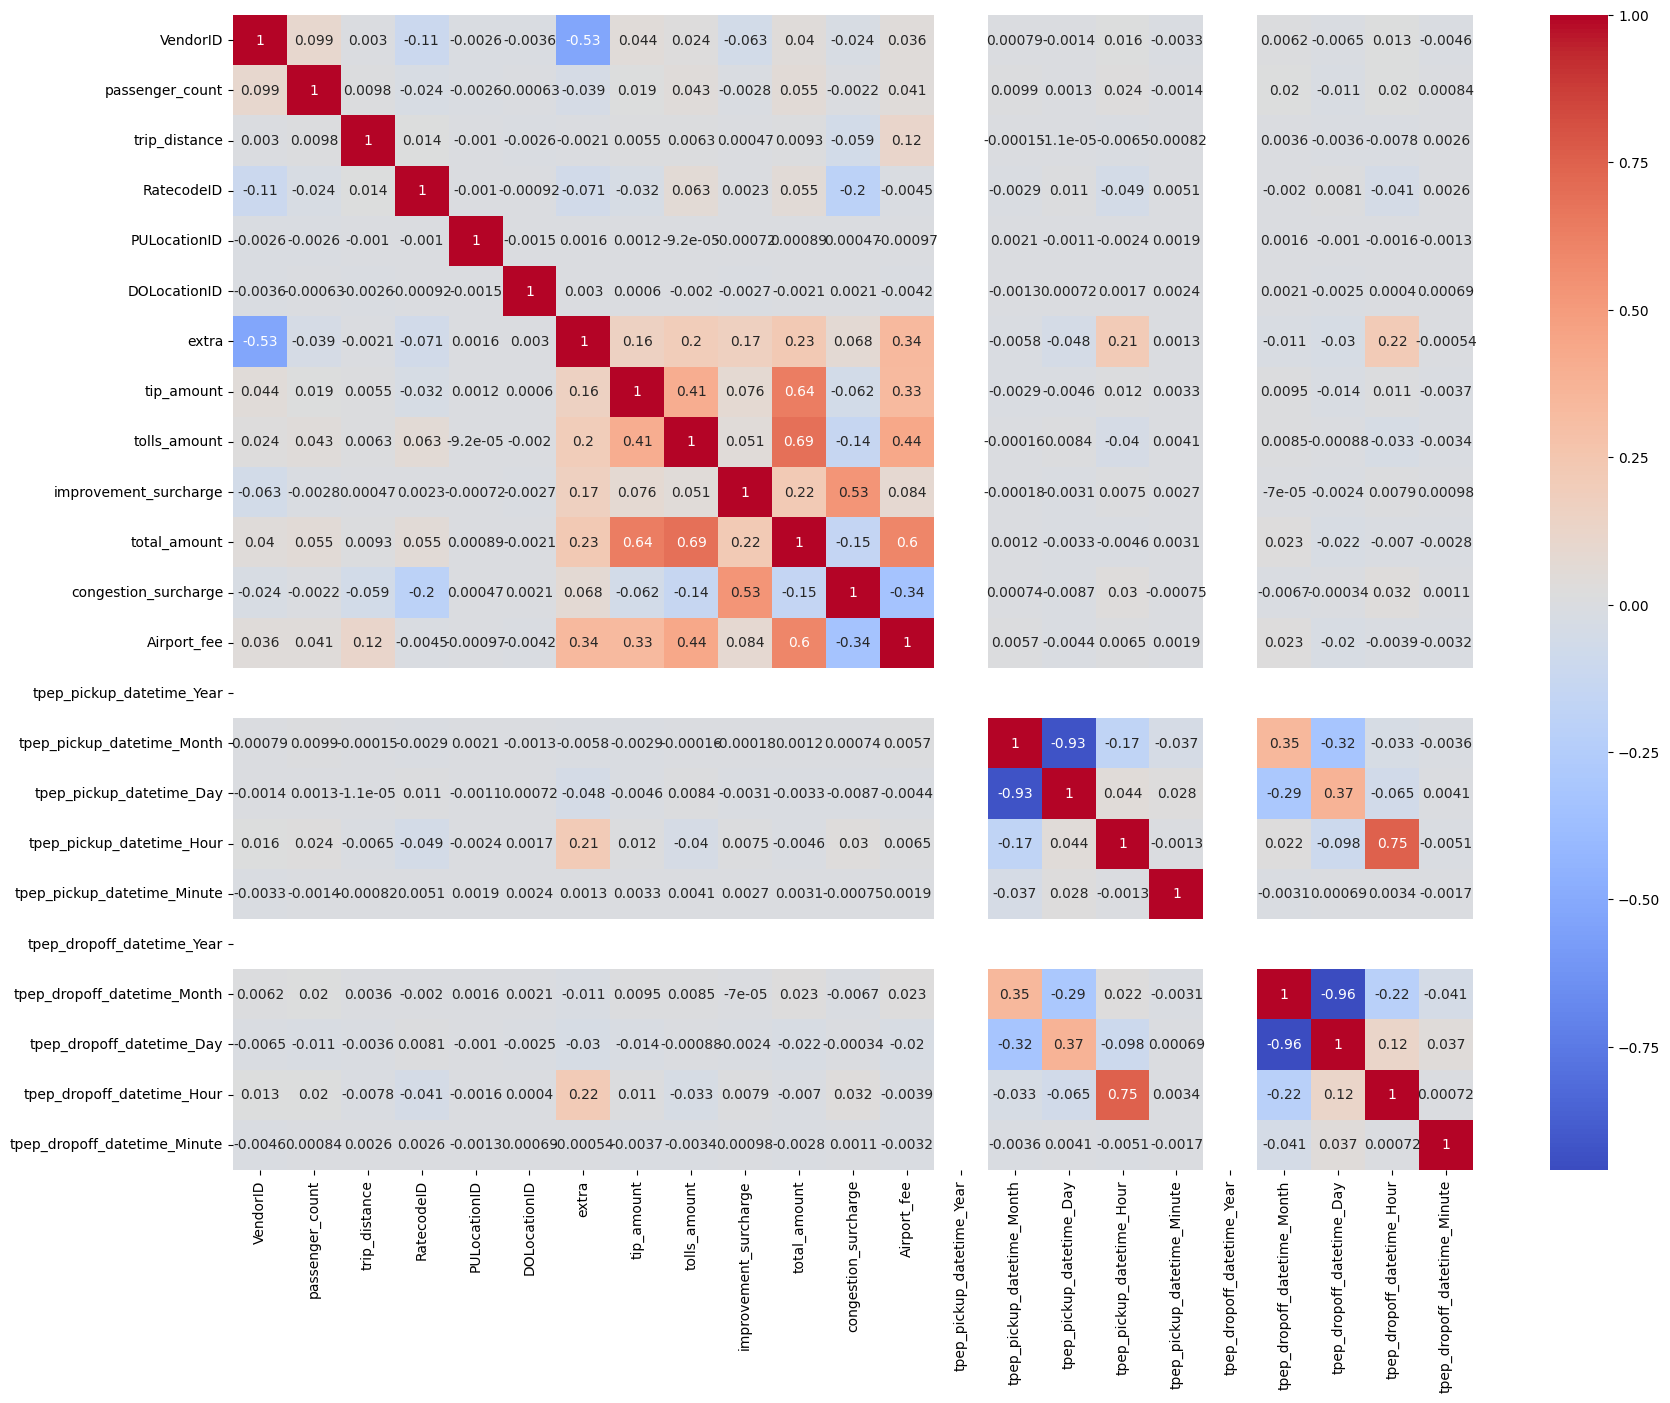

In [72]:
corr = x_train.corr(numeric_only=True)
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm')

### Recursive features elimination

In [75]:
from sklearn.feature_selection import RFE

selector = RFE(linear_reg, n_features_to_select= 30, step=1, verbose= 1)
selector = selector.fit(com_train_features, com_train_labels)


Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.


In [76]:
selector.support_

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True, False,  True,
       False])

In [77]:
selector.ranking_

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 5, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 7, 1, 1, 1, 1, 8, 1, 1, 6, 1, 4])

In [78]:
selector.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22',
       'x23', 'x24', 'x25', 'x27', 'x28', 'x29', 'x30', 'x32', 'x33',
       'x35'], dtype=object)

In [79]:
selector.score(dev_test_features, dev_test_labels)

0.7832052866833223

In [80]:
selector.score(x_test_t, y_test)

0.7535262000380043

## checking cross validation

In [34]:
def printTestResult(result, model:str):
  train_error, test_error = -1 * result['train_score'],  -1 * result['test_score']
  print(f'Mean absolute error of {model} model on the train set:\n',
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

  print(f'Mean absolute error of linear {model} on the test set:\n',
      f'{test_error.mean():.3f} +/- {test_error.std():.3f}')

In [35]:
cv_5 = ShuffleSplit(n_splits= 5, test_size= 0.2, random_state= 42)
lin_reg_cross_validation = cross_validate(
  linear_reg,
  com_train_features,
  com_train_labels,
  cv=cv_5,
  scoring= 'neg_mean_squared_error',
  return_train_score= True,
  return_estimator= True)
printTestResult(lin_reg_cross_validation, 'Linear Regression')
lin_reg_cross_validation['estimator'][0].score(dev_test_features, dev_test_labels)

Mean absolute error of Linear Regression model on the train set:
 149.263 +/- 2.218
Mean absolute error of linear Linear Regression on the test set:
 134.558 +/- 8.940


0.7978658591037463

### checking grid search cv

In [36]:
params = {
  'ridge__alpha': [0.1, 0.01, 0.001, 0.5, 0.05, 0.005, 0.00001, 0]
}

In [37]:
lasso_regression = Lasso()
lasso_regression.fit(com_train_features, com_train_labels)

Lasso()

In [38]:
print(lasso_regression.score(com_train_features, com_train_labels))
print(lasso_regression.score(dev_test_features, dev_test_labels))


0.7172156186406364
0.7439269893472206


In [39]:
ridge_regression = Ridge()
ridge_regression.fit(com_train_features, com_train_labels)

Ridge()

In [40]:
print(ridge_regression.score(com_train_features, com_train_labels))
print(ridge_regression.score(dev_test_features, dev_test_labels))

0.7726177711148223
0.7978762232040884


In [41]:
X_t

array([[ 0.  ,  1.  ,  0.  , ...,  0.98, 17.  , 44.  ],
       [ 0.  ,  1.  ,  0.  , ...,  0.89,  0.  , 10.  ],
       [ 0.  ,  1.  ,  0.  , ...,  0.8 , 20.  , 38.  ],
       ...,
       [ 1.  ,  0.  ,  0.  , ..., 16.1 , 12.  , 36.  ],
       [ 0.  ,  1.  ,  0.  , ...,  0.89, 14.  , 58.  ],
       [ 0.  ,  1.  ,  0.  , ...,  0.59, 13.  , 57.  ]])

In [42]:
ridge_pipeline = Pipeline([
  # ('feature_trans', feature_scaling_and_trans),
  ('ridge', ridge_regression)
])

hpt_ridge = GridSearchCV(ridge_pipeline, param_grid=params,
                         cv= cv_5,
                         return_train_score= True,
                         scoring= 'neg_mean_squared_error'
                         )
# type()
hpt_ridge_result = hpt_ridge.fit(com_train_features, com_train_labels)


In [43]:
hpt_ridge_result.best_estimator_.score(dev_test_features, dev_test_labels)

0.797897130742822

In [44]:
hpt_ridge_result.best_estimator_.score(com_train_features, com_train_labels)

0.7726408321428092

In [45]:
hpt_ridge_result.best_params_

{'ridge__alpha': 1e-05}

In [46]:
# impute_unknown_values(test_pd)
convert_dt_obj_to_datetime(test_pd, 'tpep_pickup_datetime')
test_pd = test_pd.drop('tpep_pickup_datetime', axis= 1)

convert_dt_obj_to_datetime(test_pd, 'tpep_dropoff_datetime')
test_pd = test_pd.drop('tpep_dropoff_datetime', axis= 1)


In [47]:
test_pd_t = feature_scaling_and_trans.transform(test_pd)

In [48]:
prediction = lin_reg_cross_validation['estimator'][0].predict(test_pd_t)

In [49]:
prediction = hpt_ridge_result.best_estimator_.predict(test_pd_t)

In [50]:
submission = pd.DataFrame(columns= ['ID', "total_amount"])
submission['ID'] = [i for i in range(1, 50001)]
submission['total_amount'] = prediction
submission.to_csv('submission.csv', index=False)

### testing SVR algo

In [51]:
svr = SVR(kernel= 'linear')
# svr.fit(com_train_features, com_train_labels)

In [52]:
# svr.score(com_train_features, com_train_labels)

In [53]:
# svr.score(dev_test_features, dev_test_labels)

In [54]:
# svr.score(x_test_t, y_test)

In [55]:
submission.describe()

,ID,total_amount
count,50000.000000,50000.000000
mean,25000.500000,29.386580
std,14433.901067,21.944409
min,1.000000,-90.044232
25%,12500.750000,19.617701
50%,25000.500000,23.241379
75%,37500.250000,28.221859
max,50000.000000,278.025297


In [56]:
submission[submission['total_amount'] < 0]

,ID,total_amount
12,13,-36.960476
99,100,-23.165921
133,134,-31.005174
199,200,-30.372545
419,420,-28.402341
...,...,...
49714,49715,-52.761824
49741,49742,-29.266604
49858,49859,-24.223663
49867,49868,-0.120370
